In [1]:
from dotenv import load_dotenv
load_dotenv(".env", override=True)
%load_ext autoreload
%autoreload 2

# Deepagent for Research

We will use the `deepagents` package to create a research agent. When using the `deepagents` package, it's important to: 

1. Understand the native tools available
2. Supply task-specific tools
3. Supply task-specific instructions
4. Supply task-specific sub-agents

## Task-Specific Tools 

You can see an overview of the native tools in the [deepagents package README](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#model) as well as the [quickstarts README](https://github.com/langchain-ai/deepagents-quickstarts). We'll extend this with two task-specific tools. 

### Search Tool 

There are different search tools that we can use. For example, we can use [Tavily](https://www.tavily.com/) to search for relevant URLs, then fetches the full webpage content.

### Think Tool 

We'll supply a [think tool](https://www.anthropic.com/engineering/claude-think-tool), which is a useful way to help audit agent decision making. 

In [2]:
from research_agent.tools import tavily_search, think_tool
tools = [tavily_search, think_tool]

## Task-Specific Instructions
 
Next, let's define task specific instructions using [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

In [3]:
from datetime import datetime
from utils import show_prompt, format_messages
from research_agent.prompts import (
    RESEARCHER_INSTRUCTIONS,
    RESEARCH_WORKFLOW_INSTRUCTIONS,
    SUBAGENT_DELEGATION_INSTRUCTIONS,
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the research tools provided to you to find resources that can help answer the research      │
│  question.                                                                                                      │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Research Tools>                                                                                     │
│  You have access to two specific research tools:                                                                │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Research Tools>                                                                                    │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

## Task-Specific Sub-Agents

You can specify [custom subagents](https://github.com/langchain-ai/deepagents?tab=readme-ov-file#subagents) as a means of context isolation. 

Here's well define a sub-agent that can search the web for information. 

In [5]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [tavily_search, think_tool],
}

## Putting it all together

### Instructions

Now, we can look at all of our instructions together. 

In [6]:
# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Combine orchestrator instructions (RESEARCHER_INSTRUCTIONS only for sub-agents)
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    +  SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Research Workflow                                                                                            │
│                                                                                                                 │
│  Follow this workflow for all research requests:                                                                │
│                                                                                                                 │
│  1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks                 │
│  2. **Save the request**: Use write_file() to save the user's research question to `/research_request.md`       │
│  3. **Research**: Delegate research tasks to sub-agents using the task() tool - ALWAYS use sub-agents for       │
│  research, never conduct research yourself                                                                      │
│  4. **Synthesize**: Review all sub-agent findings and consolidate citations (each unique URL gets one number    │
│  across all findings)                                                                                           │
│  5. **Write Report**: Write a comprehensive final report to `/final_report.md` (see Report Writing Guidelines   │
│  below)                                                                                                         │
│  6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects with proper citations and  │
│  structure                                                                                                      │
│                                                                                                                 │
│  ## Research Planning Guidelines                                                                                │
│  - Batch similar research tasks into a single TODO to minimize overhead                                         │
│  - For simple fact-finding questions, use 1 sub-agent                                                           │
│  - For comparisons or multi-faceted topics, delegate to multiple parallel sub-agents                            │
│  - Each sub-agent should research one specific aspect and return findings                                       │
│                                                                                                                 │
│  ## Report Writing Guidelines                                                                                   │
│                                                                                                                 │
│  When writing the final report to `/final_report.md`, follow these structure patterns:                          │
│                                                                                                                 │
│  **For comparisons:**                                                                                           │
│  1. Introduction                                                                                                │
│  2. Overview of topic A                                                                                         │
│  3. Overview of topic B                                                                                         │
│  4. Detailed comparison                                                                                         │
│  5. Conclusion                                                                                                  │
│                                                                                                                 │
│  **For lists/rankings:**                              

### Create the agent

Now, we create our deepagent with these components. 

In [14]:
from IPython.display import Image, display
from deepagents import create_deep_agent
#from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI

# Model Gemini 3 
model = ChatGoogleGenerativeAI(model="gemini-3-pro-preview")

# Model Claude 4.5
#model = init_chat_model(model="anthropic:claude-sonnet-4-5-20250929", temperature=0.0)

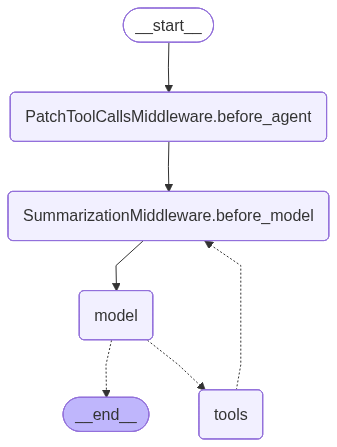

In [10]:
# Create the agent
agent = create_deep_agent(
      model=model,
      tools=tools, 
      system_prompt=INSTRUCTIONS,
      subagents=[research_sub_agent],
  )
  
# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "research qi men dun jia divination methods used to predict events and occurences in business strategies",
            }
        ],
    }, 
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research qi men dun jia divination methods used to predict events and occurences in business strategies         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 18386785-af98-496e-8a35-3478cd20a884                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "research qi men dun jia divination methods used to predict events and occurences in business      │
│ strategies",                                                                                                    │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: 6ba69141-2fe6-4b6b-8c68-8016f25f1c51                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'in_progress'},    │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'pending'}, {'content': 'Synthesize findings    │
│ and write final report to /final_report.md', 'status': 'pending'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 760f5449-e028-4da3-a8eb-c52980a6f84e                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research Qi Men Dun Jia (QMDJ) divination methods specifically used for business strategy and │
│ event prediction.\n\nFocus on:\n1. Core QMDJ concepts relevant to business (The 10 Stems, 8 Doors, 9 Stars, 8   │
│ Deities and their business meanings).\n2. Specific divination methods/techniques for forecasting business       │
│ outcomes (e.g., launching a product, negotiations, investments, hiring).\n3. How to interpret a QMDJ chart for  │
│ business decision making (identifying the 'Yong Shen' or Useful God for different business scenarios).\n4.      │
│ Strategic applications: How it is used to time actions (choosing auspicious dates/times) and direction.\n5. Any │
│ common frameworks or schools of thought regarding QMDJ in modern business consulting.\n\nProvide a              │
│ comprehensive summary with citations."                                                                          │
│ }                                                                                                               │
│    ID: ba1e5e6f-1fc7-497f-859e-1269b47afdad                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'in_progress'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Qi Men Dun Jia (QMDJ) for Business Strategy and Event Prediction                                             │
│                                                                                                                 │
│ Qi Men Dun Jia (QMDJ) is an ancient Chinese metaphysical art originally designed for military strategy, now     │
│ adapted for modern business decision-making. Unlike other divination methods that focus solely on "destiny,"    │
│ QMDJ is a strategic tool used to place oneself in the most advantageous position in space and time to achieve a │
│ desired outcome [1, 2].                                                                                         │
│                                                                                                                 │
│ The following sections detail the core concepts, divination methods, and strategic applications for business.   │
│                                                                                                                 │
│ ### 1. Core QMDJ Concepts in Business                                                                           │
│ In a business QMDJ chart, the four layers (Heaven, Earth, Man, and Deities) correspond to different aspects of  │
│ a business environment.                                                                                         │
│                                                                                                                 │
│ #### **The 10 Stems (The Players & Capital)**                                                                   │
│ The Heavenly Stems often represent the key actors and assets in a business scenario [2, 3].                     │
│ *   **Jia (Yang Wood):** The Boss, CEO, or Leader. Usually hidden in the chart; represented by the "Leader"     │
│ deity.                                                                                                          │
│ *   **Yi (Yin Wood):** The Doctor/Healer. In business, it represents *solutions*, the wife/female partner, or   │
│ soft skills/diplomacy.                                                                                          │
│ *   **Bing (Yang Fire):** The Trouble-maker or Revolutionary. Represents *chaos*, but also unwanted third       │
│ parties or aggressive competitors.                                                                              │
│ *   **Ding (Yin Fire):** The Inspiration. Represents *hope*, documents, contracts, or a crucial piece of        │
│ information/profit potential.                                                                                   │
│ *   **Wu (Yang Earth):** The Capital. Represents *money*, cash flow, assets, and wealth. Essential for          │
│ investment forecasting.                                                                                         │
│ *   **Ji (Yin Earth):** The Planner. Represents *marketing*, inner thoughts, or hidden agendas.                 │
│ *   **Geng (Yang Metal):** The Enemy. Represents *obstacles*, major competitors, or the police/regulators.      │
│ *   **Xin (Yin Metal):** The Mistake. Represents *errors*, small profits, or innovation (new metal).            │
│ *   **Ren (Yang Water):** The Traveller. Represents *logistics*, flow of goods, transport, or movement.         │
│ *   **Gui (Yin Water):** The Spy. Represents *intelligence*, networks, or hidden information.                   │
│                                                                                                                 │
│ #### **The 8 Doors (The Action & Status)**                                                                      │
│ The Doors (Man Plate) represent the status of human activities and are critical for predicting the outcome of   │
│ actions [3, 4].                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 27df8a73-4294-4ea5-bdff-082e9f910299                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research advanced Qi Men Dun Jia (QMDJ) business applications.\n\nSpecifically find:\n1.      │
│ **Case Studies/Walkthroughs**: Detailed examples of QMDJ charts used for business (e.g., \"A client asked about │
│ a merger... here is the chart... here is the interpretation\").\n2.  **Auspicious & Inauspicious Structures**:  │
│ Definitions and business implications of major formations like \"Green Dragon Returns,\" \"Flying Bird Falls    │
│ into Cave,\" \"Penalties,\" and \"Fu Yin / Fan Yin\" char

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'in_progress'}, {'content':    │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'pending'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research advanced Qi Men Dun Jia (QMDJ) business applications and examples.\n\nPlease find    │
│ and explain:\n1.  **Auspicious Structures**: Explain \"Green Dragon Returns\" (Qing Long Fan Shou) and \"Flying │
│ Bird Falls into Cave\" (Fei Niao Die Xue) and their meaning in business/wealth.\n2.  **Inauspicious             │
│ Structures**: Explain \"Fu Yin\" (Repeated\u541f) and \"Fan Yin\" (Reverse\u541f) charts and what they mean for │
│ business stability.\n3.  **The Concept of Void (Xun Kong)**: What does it mean when a focal point (Yong Shen)   │
│ falls into a Void palace in a business forecast? (e.g., failed deal, false information).\n4.  **Competitive     │
│ Intelligence**: How to analyze the 'Geng' stem (Enemy) vs. the 'Jia' (Leader) or Day Stem to predict competitor │
│ moves.\n5.  **Case Study**: Try to find a specific example or summary of a QMDJ business prediction (e.g., an   │
│ investment decision or lawsuit outcome).\n\nProvide definitions and practical business interpretations."        │
│ }                                                                                                               │
│    ID: 8792f04f-e759-4b8f-b8a7-3bc2868d165d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The following research outlines advanced **Qi Men Dun Jia (QMDJ)** applications for business, focusing on       │
│ specific auspicious and inauspicious structures, the concept of Void, competitive intelligence, and real-world  │
│ case studies.                                                                                                   │
│                                                                                                                 │
│ ### 1. Auspicious Structures: The "Royal" Formations                                                            │
│ These rare formations are highly prized in business forecasting and date selection as they indicate smooth      │
│ success and high returns.                                                                                       │
│                                                                                                                 │
│ *   **Green Dragon Returns (Qing Long Fan Shou)**                                                               │
│     *   **Structure:** **Heaven Plate Wu** (representing *Jia* / The Leader) falls on **Earth Plate Bing**.     │
│         *   *Note: In QMDJ, Jia hides under Wu. The formation is Wood (Jia) producing Fire (Bing).*             │
│     *   **Business Meaning:** This is the "Midas Touch" structure. It signifies a powerful comeback, high       │
│ return on investment, and the ability to turn a bad situation into a good one. It is excellent for launching    │
│ new products, recovering debts, or restarting a stalled project.                                                │
│     *   **Key Attribute:** "Action brings reward." You must act to get the benefit.                             │
│                                                                                                                 │
│ *   **Flying Bird Falls into Cave (Fei Niao Die Xue)**                                                          │
│     *   **Structure:** **Heaven Plate Bing** falls on **Earth Plate Wu** (representing *Jia*).                  │
│         *   *Note: Fire (Bing) returning to its source/parent Wood (Jia).*                                      │
│     *   **Business Meaning:** This structure represents "easy success" or opportunities coming to you without   │
│ effort. It is like a bird finding its nest easily.                                                              │
│     *   **Key Attribute:** "Windfall luck." Ideal for investments, receiving funding, or winning a lawsuit by   │
│ default. Unlike Green Dragon, success here often happens naturally without strenuous effort.                    │
│                                                                                                                 │
│ ### 2. Inauspicious Structures: Stability vs. Chaos                                                             │
│ These charts describe the *movement* of energy and are critical for timing business moves.                      │
│                                                                                                                 │
│ *   **Fu Yin (Repeated Chant)**                                                                                 │
│     *   **Structure:** The Stems on the Heaven Plate are identical to the Stems on the Earth Plate (e.g., Jia   │
│ on Jia, Yi on Yi) in every palace.                                                                              │
│     *   **Business Meaning:** **Stagnation and Immutability.** Things are stuck. It represents a long, painful  │
│ process with no progress.                                                                                       │
│     *   **Strategic Advice:** Do not start new ventures. It is a terrible time for aggressive expansion or      │
│ launching a startup. It is, however, suitable for maint

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: a7b91dc3-8852-4cfc-9f2e-058c03a392fe                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Qi Men Dun Jia Divination Methods for Business Strategy\n\nQi Men Dun Jia (QMDJ) is an ancient  │
│ Chinese metaphysical system originally developed for military strategy. In modern times, it has been adapted as │
│ a sophisticated tool for business forecasting, strategic execution, and competitive intelligence. Unlike simple │
│ fortune-telling, QMDJ focuses on placing oneself in the optimal position in time and space to manipulate        │
│ outcomes.\n\n## 1. Core Concepts in Business QMDJ\nA QMDJ chart consists of four plates (Heaven, Earth, Man,    │
│ Deity) representing different dimensions of a business en

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'in_progress'}]                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 77c42dfe-7668-436e-a4f8-798d1b180394                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'completed'}]                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The research on Qi Men Dun Jia (QMDJ) divination methods for business strategy has been completed. The final    │
│ report is saved to `/final_report.md` and covers core concepts, forecasting techniques for investments and      │
│ negotiations, strategic timing, and real-world application examples.                                            │
│                                                                                                                 │
│ ### Research Summary                                                                                            │
│                                                                                                                 │
│ **Qi Men Dun Jia (QMDJ)** is a strategic metaphysical system used in business to forecast outcomes and optimize │
│ decision-making by analyzing the interaction of time, space, and event variables.                               │
│                                                                                                                 │
│ #### 1. Core Forecasting Concepts                                                                               │
│ *   **The 10 Stems (The Actors):** Key players in the business landscape.                                       │
│     *   **Wu (Yang Earth):** Represents **Capital** and money.                                                  │
│     *   **Geng (Yang Metal):** Represents **Competitors** or obstacles.                                         │
│     *   **Ding (Yin Fire):** Represents **Documents**, contracts, and inspiration.                              │
│ *   **The 8 Doors (The Activities):** The status of the business action.                                        │
│     *   **Life Door (Sheng Men):** The focal point for **Profits** and growth.                                  │
│     *   **Open Door (Kai Men):** Represents the **Company**, career, and new ventures.                          │
│     *   **View Door (Jing Men):** Critical for **Marketing**, reputation, and presentations.                    │
│ *   **The 8 Deities (The Unseen Forces):** Universal influences.                                                │
│     *   **Chief (Zhi Fu):** Represents **Success** and mentorship.                                              │
│     *   **Harmony (Liu He):** Represents **Partnerships** and deals.                                            │
│                                                                                                                 │
│ #### 2. Key Divination Methods (Yong Shen)                                                                      │
│ *   **Investment Success:** Analyze the relationship between **Wu (Capital)** and **Life Door (Profit)**.       │
│     *   *Auspicious:* Life Door palace produces (supports) the Wu palace = Profit.                              │
│     *   *Inauspicious:* Life Door clashes with Wu = Loss of capital.                                            │
│ *   **Negotiations:** Compare the **Day Stem (You)** vs. **Hour Stem (Counterpart)**.                           │
│     *   *Win:* Your palace controls the counterpart's palace.                                                   │
│     *   *Deal:* Palaces are in harmony.                                                                         │
│     *   *Void:* If the Harmony deity falls into a "Void" (Empty) palace, the deal is likely fake or insincere.  │
│                                                                                                                 │
│ #### 3. Strategic Formations                                                                                    │
│ *   **Green Dragon Returns:** A rare, highly auspicious structure indicating high ROI and successful comebacks. │
│ *   **Flying Bird Falls into Cave:** Indicates "windfal

In [12]:
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ research qi men dun jia divination methods used to predict events and occurences in business strategies         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 18386785-af98-496e-8a35-3478cd20a884                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "research qi men dun jia divination methods used to predict events and occurences in business      │
│ strategies",                                                                                                    │
│   "file_path": "/research_request.md"                                                                           │
│ }                                                                                                               │
│    ID: 6ba69141-2fe6-4b6b-8c68-8016f25f1c51                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'in_progress'},    │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'pending'}, {'content': 'Synthesize findings    │
│ and write final report to /final_report.md', 'status': 'pending'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /research_request.md                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 760f5449-e028-4da3-a8eb-c52980a6f84e                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research Qi Men Dun Jia (QMDJ) divination methods specifically used for business strategy and │
│ event prediction.\n\nFocus on:\n1. Core QMDJ concepts relevant to business (The 10 Stems, 8 Doors, 9 Stars, 8   │
│ Deities and their business meanings).\n2. Specific divination methods/techniques for forecasting business       │
│ outcomes (e.g., launching a product, negotiations, investments, hiring).\n3. How to interpret a QMDJ chart for  │
│ business decision making (identifying the 'Yong Shen' or Useful God for different business scenarios).\n4.      │
│ Strategic applications: How it is used to time actions (choosing auspicious dates/times) and direction.\n5. Any │
│ common frameworks or schools of thought regarding QMDJ in modern business consulting.\n\nProvide a              │
│ comprehensive summary with citations."                                                                          │
│ }                                                                                                               │
│    ID: ba1e5e6f-1fc7-497f-859e-1269b47afdad                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'in_progress'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ## Qi Men Dun Jia (QMDJ) for Business Strategy and Event Prediction                                             │
│                                                                                                                 │
│ Qi Men Dun Jia (QMDJ) is an ancient Chinese metaphysical art originally designed for military strategy, now     │
│ adapted for modern business decision-making. Unlike other divination methods that focus solely on "destiny,"    │
│ QMDJ is a strategic tool used to place oneself in the most advantageous position in space and time to achieve a │
│ desired outcome [1, 2].                                                                                         │
│                                                                                                                 │
│ The following sections detail the core concepts, divination methods, and strategic applications for business.   │
│                                                                                                                 │
│ ### 1. Core QMDJ Concepts in Business                                                                           │
│ In a business QMDJ chart, the four layers (Heaven, Earth, Man, and Deities) correspond to different aspects of  │
│ a business environment.                                                                                         │
│                                                                                                                 │
│ #### **The 10 Stems (The Players & Capital)**                                                                   │
│ The Heavenly Stems often represent the key actors and assets in a business scenario [2, 3].                     │
│ *   **Jia (Yang Wood):** The Boss, CEO, or Leader. Usually hidden in the chart; represented by the "Leader"     │
│ deity.                                                                                                          │
│ *   **Yi (Yin Wood):** The Doctor/Healer. In business, it represents *solutions*, the wife/female partner, or   │
│ soft skills/diplomacy.                                                                                          │
│ *   **Bing (Yang Fire):** The Trouble-maker or Revolutionary. Represents *chaos*, but also unwanted third       │
│ parties or aggressive competitors.                                                                              │
│ *   **Ding (Yin Fire):** The Inspiration. Represents *hope*, documents, contracts, or a crucial piece of        │
│ information/profit potential.                                                                                   │
│ *   **Wu (Yang Earth):** The Capital. Represents *money*, cash flow, assets, and wealth. Essential for          │
│ investment forecasting.                                                                                         │
│ *   **Ji (Yin Earth):** The Planner. Represents *marketing*, inner thoughts, or hidden agendas.                 │
│ *   **Geng (Yang Metal):** The Enemy. Represents *obstacles*, major competitors, or the police/regulators.      │
│ *   **Xin (Yin Metal):** The Mistake. Represents *errors*, small profits, or innovation (new metal).            │
│ *   **Ren (Yang Water):** The Traveller. Represents *logistics*, flow of goods, transport, or movement.         │
│ *   **Gui (Yin Water):** The Spy. Represents *intelligence*, networks, or hidden information.                   │
│                                                                                                                 │
│ #### **The 8 Doors (The Action & Status)**                                                                      │
│ The Doors (Man Plate) represent the status of human activities and are critical for predicting the outcome of   │
│ actions [3, 4].                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 27df8a73-4294-4ea5-bdff-082e9f910299                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research advanced Qi Men Dun Jia (QMDJ) business applications.\n\nSpecifically find:\n1.      │
│ **Case Studies/Walkthroughs**: Detailed examples of QMDJ charts used for business (e.g., \"A client asked about │
│ a merger... here is the chart... here is the interpretation\").\n2.  **Auspicious & Inauspicious Structures**:  │
│ Definitions and business implications of major formations like \"Green Dragon Returns,\" \"Flying Bird Falls    │
│ into Cave,\" \"Penalties,\" and \"Fu Yin / Fan Yin\" char

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'in_progress'}, {'content':    │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'pending'}]                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Research advanced Qi Men Dun Jia (QMDJ) business applications and examples.\n\nPlease find    │
│ and explain:\n1.  **Auspicious Structures**: Explain \"Green Dragon Returns\" (Qing Long Fan Shou) and \"Flying │
│ Bird Falls into Cave\" (Fei Niao Die Xue) and their meaning in business/wealth.\n2.  **Inauspicious             │
│ Structures**: Explain \"Fu Yin\" (Repeated\u541f) and \"Fan Yin\" (Reverse\u541f) charts and what they mean for │
│ business stability.\n3.  **The Concept of Void (Xun Kong)**: What does it mean when a focal point (Yong Shen)   │
│ falls into a Void palace in a business forecast? (e.g., failed deal, false information).\n4.  **Competitive     │
│ Intelligence**: How to analyze the 'Geng' stem (Enemy) vs. the 'Jia' (Leader) or Day Stem to predict competitor │
│ moves.\n5.  **Case Study**: Try to find a specific example or summary of a QMDJ business prediction (e.g., an   │
│ investment decision or lawsuit outcome).\n\nProvide definitions and practical business interpretations."        │
│ }                                                                                                               │
│    ID: 8792f04f-e759-4b8f-b8a7-3bc2868d165d                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The following research outlines advanced **Qi Men Dun Jia (QMDJ)** applications for business, focusing on       │
│ specific auspicious and inauspicious structures, the concept of Void, competitive intelligence, and real-world  │
│ case studies.                                                                                                   │
│                                                                                                                 │
│ ### 1. Auspicious Structures: The "Royal" Formations                                                            │
│ These rare formations are highly prized in business forecasting and date selection as they indicate smooth      │
│ success and high returns.                                                                                       │
│                                                                                                                 │
│ *   **Green Dragon Returns (Qing Long Fan Shou)**                                                               │
│     *   **Structure:** **Heaven Plate Wu** (representing *Jia* / The Leader) falls on **Earth Plate Bing**.     │
│         *   *Note: In QMDJ, Jia hides under Wu. The formation is Wood (Jia) producing Fire (Bing).*             │
│     *   **Business Meaning:** This is the "Midas Touch" structure. It signifies a powerful comeback, high       │
│ return on investment, and the ability to turn a bad situation into a good one. It is excellent for launching    │
│ new products, recovering debts, or restarting a stalled project.                                                │
│     *   **Key Attribute:** "Action brings reward." You must act to get the benefit.                             │
│                                                                                                                 │
│ *   **Flying Bird Falls into Cave (Fei Niao Die Xue)**                                                          │
│     *   **Structure:** **Heaven Plate Bing** falls on **Earth Plate Wu** (representing *Jia*).                  │
│         *   *Note: Fire (Bing) returning to its source/parent Wood (Jia).*                                      │
│     *   **Business Meaning:** This structure represents "easy success" or opportunities coming to you without   │
│ effort. It is like a bird finding its nest easily.                                                              │
│     *   **Key Attribute:** "Windfall luck." Ideal for investments, receiving funding, or winning a lawsuit by   │
│ default. Unlike Green Dragon, success here often happens naturally without strenuous effort.                    │
│                                                                                                                 │
│ ### 2. Inauspicious Structures: Stability vs. Chaos                                                             │
│ These charts describe the *movement* of energy and are critical for timing business moves.                      │
│                                                                                                                 │
│ *   **Fu Yin (Repeated Chant)**                                                                                 │
│     *   **Structure:** The Stems on the Heaven Plate are identical to the Stems on the Earth Plate (e.g., Jia   │
│ on Jia, Yi on Yi) in every palace.                                                                              │
│     *   **Business Meaning:** **Stagnation and Immutability.** Things are stuck. It represents a long, painful  │
│ process with no progress.                                                                                       │
│     *   **Strategic Advice:** Do not start new ventures. It is a terrible time for aggressive expansion or      │
│ launching a startup. It is, however, suitable for maint

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: a7b91dc3-8852-4cfc-9f2e-058c03a392fe                                                                     │
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "content": "# Qi Men Dun Jia Divination Methods for Business Strategy\n\nQi Men Dun Jia (QMDJ) is an ancient  │
│ Chinese metaphysical system originally developed for military strategy. In modern times, it has been adapted as │
│ a sophisticated tool for business forecasting, strategic execution, and competitive intelligence. Unlike simple │
│ fortune-telling, QMDJ focuses on placing oneself in the optimal position in time and space to manipulate        │
│ outcomes.\n\n## 1. Core Concepts in Business QMDJ\nA QMDJ chart consists of four plates (Heaven, Earth, Man,    │
│ Deity) representing different dimensions of a business en

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'in_progress'}]                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /final_report.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save research request to /research_request.md",                                               │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Qi Men Dun Jia divination methods and their specific applications in business        │
│ strategy (concepts, forecasting techniques, decision making)",                                                  │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research specific QMDJ business case studies, advanced auspicious/inauspicious structures     │
│ (Green Dragon, Flying Bird, etc.), the impact of 'Void/Emptiness', and competitive intelligence techniques.",   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and write final report to /final_report.md",                              │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: 77c42dfe-7668-436e-a4f8-798d1b180394                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save research request to /research_request.md', 'status': 'completed'},      │
│ {'content': 'Research Qi Men Dun Jia divination methods and their specific applications in business strategy    │
│ (concepts, forecasting techniques, decision making)', 'status': 'completed'}, {'content': "Research specific    │
│ QMDJ business case studies, advanced auspicious/inauspicious structures (Green Dragon, Flying Bird, etc.), the  │
│ impact of 'Void/Emptiness', and competitive intelligence techniques.", 'status': 'completed'}, {'content':      │
│ 'Synthesize findings and write final report to /final_report.md', 'status': 'completed'}]                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The research on Qi Men Dun Jia (QMDJ) divination methods for business strategy has been completed. The final    │
│ report is saved to `/final_report.md` and covers core concepts, forecasting techniques for investments and      │
│ negotiations, strategic timing, and real-world application examples.                                            │
│                                                                                                                 │
│ ### Research Summary                                                                                            │
│                                                                                                                 │
│ **Qi Men Dun Jia (QMDJ)** is a strategic metaphysical system used in business to forecast outcomes and optimize │
│ decision-making by analyzing the interaction of time, space, and event variables.                               │
│                                                                                                                 │
│ #### 1. Core Forecasting Concepts                                                                               │
│ *   **The 10 Stems (The Actors):** Key players in the business landscape.                                       │
│     *   **Wu (Yang Earth):** Represents **Capital** and money.                                                  │
│     *   **Geng (Yang Metal):** Represents **Competitors** or obstacles.                                         │
│     *   **Ding (Yin Fire):** Represents **Documents**, contracts, and inspiration.                              │
│ *   **The 8 Doors (The Activities):** The status of the business action.                                        │
│     *   **Life Door (Sheng Men):** The focal point for **Profits** and growth.                                  │
│     *   **Open Door (Kai Men):** Represents the **Company**, career, and new ventures.                          │
│     *   **View Door (Jing Men):** Critical for **Marketing**, reputation, and presentations.                    │
│ *   **The 8 Deities (The Unseen Forces):** Universal influences.                                                │
│     *   **Chief (Zhi Fu):** Represents **Success** and mentorship.                                              │
│     *   **Harmony (Liu He):** Represents **Partnerships** and deals.                                            │
│                                                                                                                 │
│ #### 2. Key Divination Methods (Yong Shen)                                                                      │
│ *   **Investment Success:** Analyze the relationship between **Wu (Capital)** and **Life Door (Profit)**.       │
│     *   *Auspicious:* Life Door palace produces (supports) the Wu palace = Profit.                              │
│     *   *Inauspicious:* Life Door clashes with Wu = Loss of capital.                                            │
│ *   **Negotiations:** Compare the **Day Stem (You)** vs. **Hour Stem (Counterpart)**.                           │
│     *   *Win:* Your palace controls the counterpart's palace.                                                   │
│     *   *Deal:* Palaces are in harmony.                                                                         │
│     *   *Void:* If the Harmony deity falls into a "Void" (Empty) palace, the deal is likely fake or insincere.  │
│                                                                                                                 │
│ #### 3. Strategic Formations                                                                                    │
│ *   **Green Dragon Returns:** A rare, highly auspicious structure indicating high ROI and successful comebacks. │
│ *   **Flying Bird Falls into Cave:** Indicates "windfal

In [13]:
from deepagents.backends.utils import file_data_to_string

# Convert a specific file to string
file_content = file_data_to_string(result["files"]['/final_report.md'])
show_prompt(file_content) 

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # Qi Men Dun Jia Divination Methods for Business Strategy                                                      │
│                                                                                                                 │
│  Qi Men Dun Jia (QMDJ) is an ancient Chinese metaphysical system originally developed for military strategy.    │
│  In modern times, it has been adapted as a sophisticated tool for business forecasting, strategic execution,    │
│  and competitive intelligence. Unlike simple fortune-telling, QMDJ focuses on placing oneself in the optimal    │
│  position in time and space to manipulate outcomes.                                                             │
│                                                                                                                 │
│  ## 1. Core Concepts in Business QMDJ                                                                           │
│  A QMDJ chart consists of four plates (Heaven, Earth, Man, Deity) representing different dimensions of a        │
│  business environment.                                                                                          │
│                                                                                                                 │
│  ### The 10 Stems (The Players & Capital)                                                                       │
│  The Heavenly Stems represent the key actors and assets in a business scenario.                                 │
│  *   **Jia (Yang Wood):** The Leader/CEO. Always hidden, represented by the **Chief** deity.                    │
│  *   **Yi, Bing, Ding (The Three Nobles):** The "Generals" or helpers.                                          │
│      *   **Yi (Healer):** Solutions, soft skills, networking.                                                   │
│      *   **Bing (Revolutionary):** Aggressive change, chaos, or unauthorized action.                            │
│      *   **Ding (Inspiration):** Hope, documents, contracts, and key information.                               │
│  *   **Wu (Yang Earth):** **Capital/Money**. The primary focal point for investment questions.                  │
│  *   **Ji (Yin Earth):** Planning, marketing, or hidden thoughts.                                               │
│  *   **Geng (Yang Metal):** **The Enemy**. Represents major competitors, obstacles, or the police.              │
│  *   **Xin (Yin Metal):** Errors, mistakes, or "small money"/innovation.                                        │
│  *   **Ren (Yang Water):** Logistics, movement, and transport.                                                  │
│  *   **Gui (Yin Water):** Intelligence, spies, and hidden networks.                                             │
│                                                                                                                 │
│  ### The 8 Doors (The Action/Status)                                                                            │
│  The Man Plate (Doors) indicates the state of human affairs.                                                    │
│  *   **Open Door (Kai Men):** The Company, career, and new opportunities. Best for launching ventures.          │
│  *   **Life Door (Sheng Men):** **Profits** and growth. The most important door for financial success.          │
│  *   **Rest Door (Xiu Men):** Personnel, HR, and stability. Good for internal reorganization.                   │
│  *   **Injury Door (Shang Men):** Debt collection and aggressive action (sales).                                │
│  *   **View Door (Jing Men):** Reputation, branding, and documents. Critical for marketing.                     │
│  *   **Du Door (Hide):** Secrecy, R&D, and technical s

Trace: 

https://smith.langchain.com/public/72d23852-4616-4bcc-8d8a-b0d1905c945b/r

In [19]:
result["files"]

{}